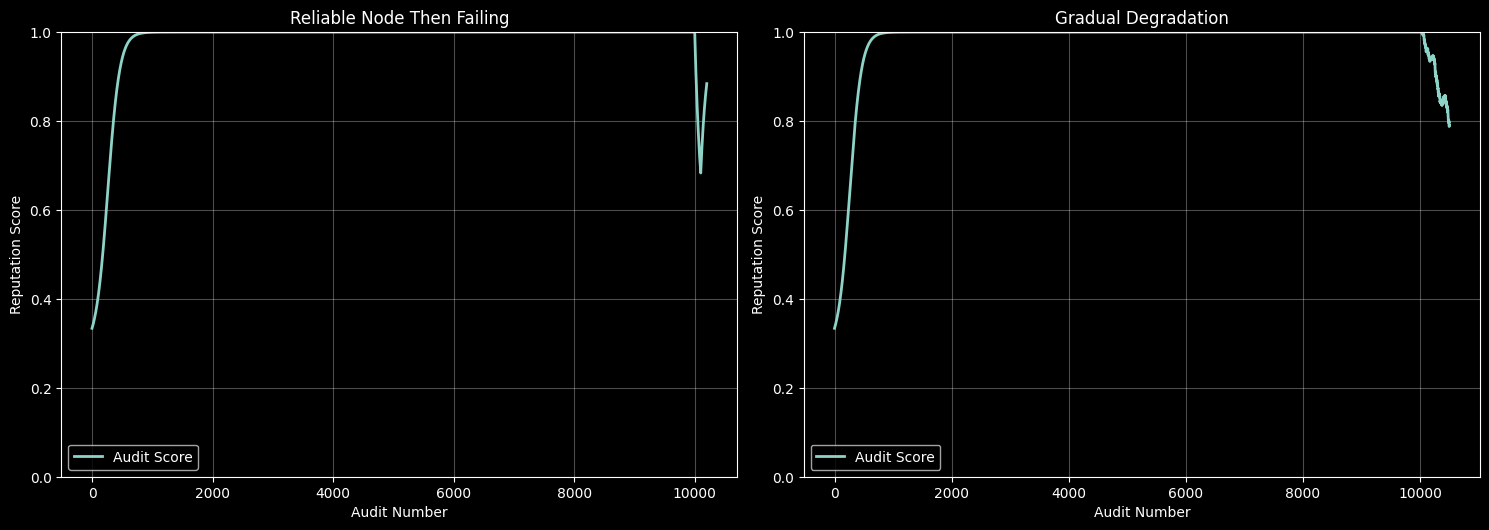

In [ ]:
# %%

import numpy as np
import matplotlib.pyplot as plt

# by default make matplotlib use dark mode
plt.style.use("dark_background")

# set np random seed for reproducibility
# convert string to seed
seed = "storb"
seed = sum(ord(c) for c in seed) % (2**32 - 1)
np.random.seed(seed)


class NodeReputationSimulator:
    def __init__(self):
        # Configuration from satellite/reputation/config.go
        self.audit_lambda = 0.99
        self.audit_weight = 1.0
        self.audit_dq = 0.96
        self.initial_alpha = 500.0
        self.initial_beta = 1000.0

        # Initialize reputation
        self.audit_alpha = self.initial_alpha
        self.audit_beta = self.initial_beta

        self.history = []

    def update_reputation_multiple(self, beta, alpha, lambda_val, weight, success):
        """Implementation of UpdateReputationMultiple from reputation package"""
        v = 1.0 if success else 0.0
        alpha = lambda_val * alpha + weight * (1 + v) / 2
        beta = lambda_val * beta + weight * (1 - v) / 2
        return beta, alpha

    def apply_audit_result(self, result_type):
        """Apply audit results: 'success', 'failure', 'offline'"""
        if result_type == "failure":
            self.audit_beta, self.audit_alpha = self.update_reputation_multiple(
                self.audit_beta,
                self.audit_alpha,
                self.audit_lambda,
                self.audit_weight,
                False,
            )
        else:
            # Success improves reputation
            self.audit_beta, self.audit_alpha = self.update_reputation_multiple(
                self.audit_beta,
                self.audit_alpha,
                self.audit_lambda,
                self.audit_weight,
                True,
            )

        # Record current state
        audit_score = self.audit_alpha / (self.audit_alpha + self.audit_beta)

        self.history.append(
            {
                "audit_score": audit_score,
                "audit_alpha": self.audit_alpha,
                "audit_beta": self.audit_beta,
                "disqualified": audit_score <= self.audit_dq,
            }
        )

    def simulate_scenario(self, scenario_name, events):
        """Simulate a sequence of audit events"""
        # print(f"\n=== {scenario_name} ===")
        self.__init__()  # Reset

        for event in events:
            self.apply_audit_result(event["type"])
            if len(self.history) % 50 == 0:  # Print every 50 audits
                last = self.history[-1]
                # print(f"Audit {len(self.history)}: Score={last['audit_score']:.4f}, "
                #       f"DQ={last['disqualified']}")

        return self.history


# Scenario 1: Reliable node that suddenly starts failing
def scenario_reliable_then_failing():
    events = []
    # 500 successful audits (building good reputation)
    events.extend([{"type": "success"} for _ in range(10000)])
    # Sudden failure period - 50 failures
    events.extend([{"type": "failure"} for _ in range(100)])
    # Try to recover with successes
    events.extend([{"type": "success"} for _ in range(100)])
    return events


# Scenario 3: Gradual degradation
def scenario_gradual_degradation():
    events = []
    # Start reliable
    events.extend([{"type": "success"} for _ in range(10000)])

    # Gradually increase failure rate
    for phase in range(10):
        failure_rate = 0.05 + (phase * 0.05)  # 5% to 50% failure rate
        for _ in range(50):
            if np.random.random() < failure_rate:
                events.append({"type": "failure"})
            else:
                events.append({"type": "success"})
    return events


# Run simulations
simulator = NodeReputationSimulator()

scenarios = [
    ("Reliable Node Then Failing", scenario_reliable_then_failing()),
    ("Gradual Degradation", scenario_gradual_degradation()),
]

plt.figure(figsize=(15, 10))

for i, (name, events) in enumerate(scenarios):
    history = simulator.simulate_scenario(name, events)

    plt.subplot(2, 2, i + 1)
    audit_scores = [h["audit_score"] for h in history]

    plt.plot(audit_scores, label="Audit Score", linewidth=2)
    # plt.axhline(y=0.96, color='red', linestyle='--', label='Audit DQ Threshold')

    plt.title(name)
    plt.xlabel("Audit Number")
    plt.ylabel("Reputation Score")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Print final statistics
# for name, events in scenarios:
#     history = simulator.simulate_scenario(name, events)
#     final = history[-1]
#     dq_point = next((i for i, h in enumerate(history) if h['disqualified']), None)

#     print(f"\n{name} Final Results:")
#     print(f"  Final Audit Score: {final['audit_score']:.4f}")
#     print(f"  Disqualified: {final['disqualified']}")
#     if dq_point:
#         print(f"  Disqualified at audit: {dq_point + 1}")

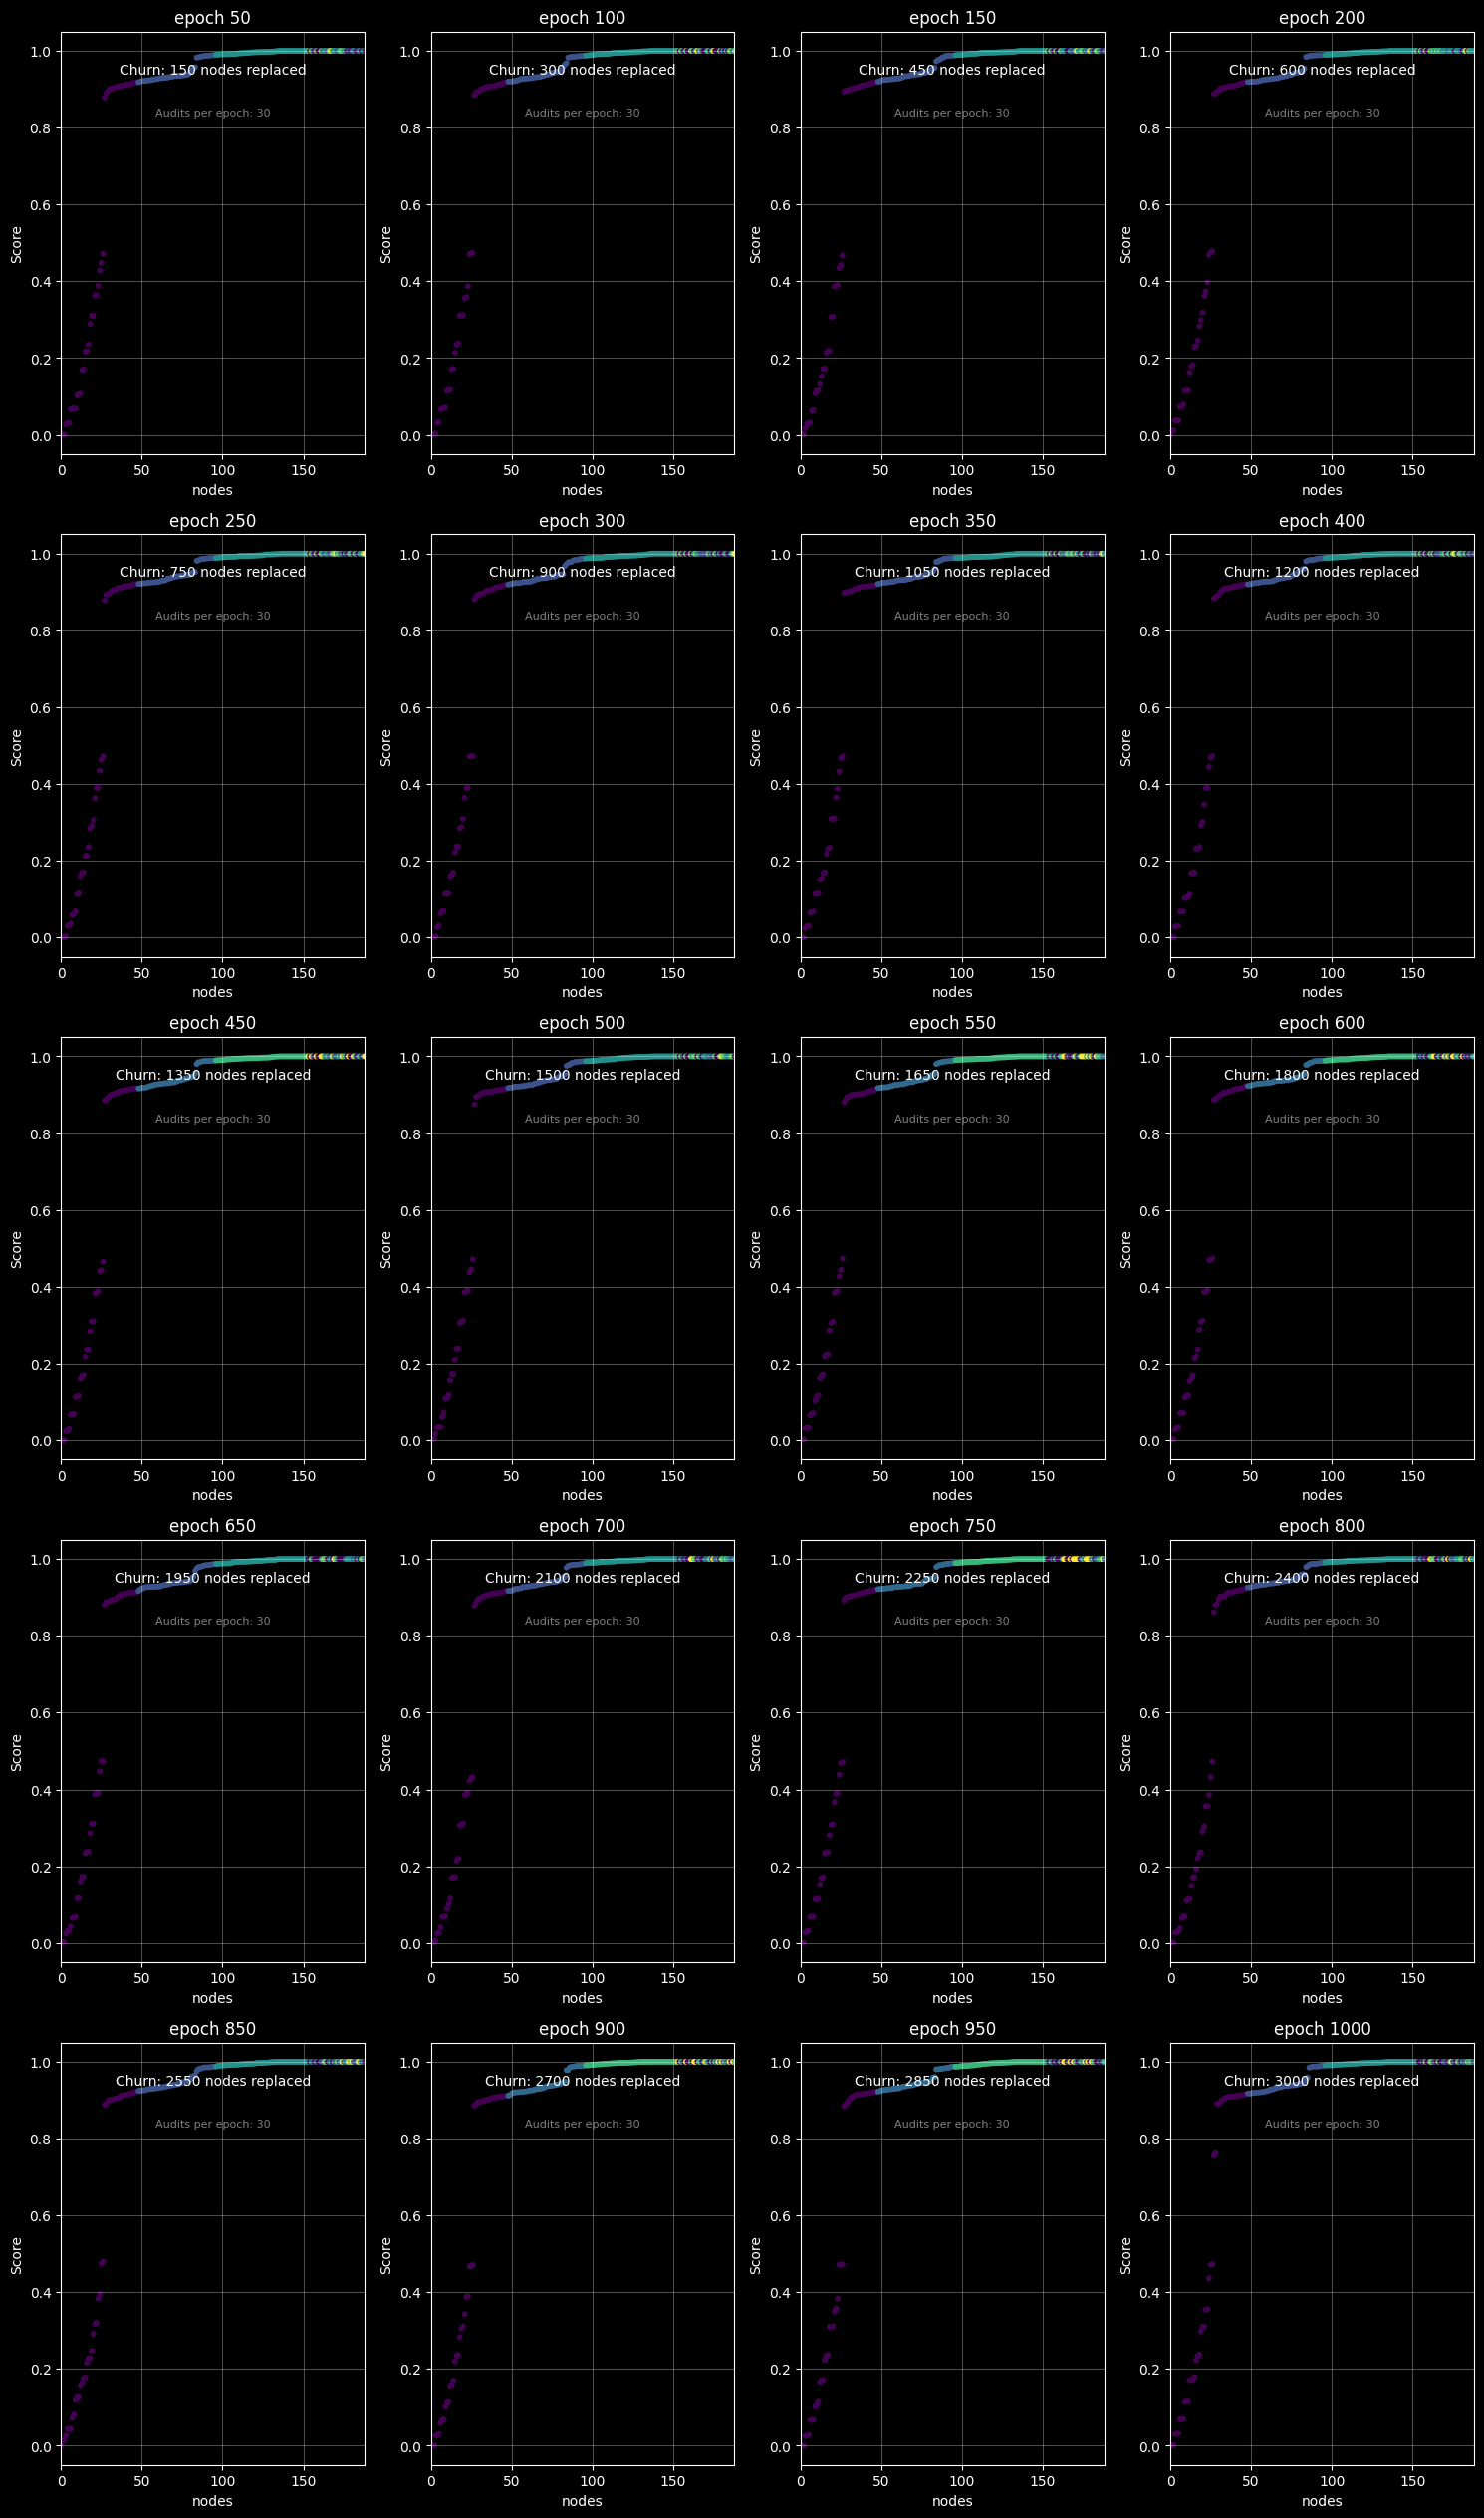

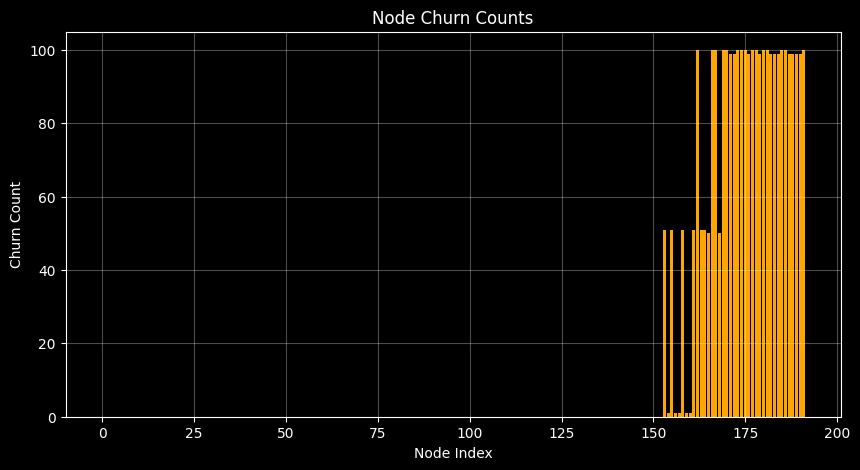


Simulation Summary:
Total epochs: 1000
Audits per epoch: 30
Total audits performed: 5,760,000
Total node churns: 0


In [ ]:
# %%

from enum import Enum


class NodeReliablity(Enum):
    VERY_RELIABLE = 1
    RELIABLE = 2
    MODERATELY_UNRELIABLE = 3
    DEGRADING = 4
    GARBAGE = 5


def run_simulation_with_node_churn():
    """Run a simulation with node churn, where nodes are replaced based on their reputation scores."""
    num_nodes = 192
    epochs = 1000
    interval = 50  # Plot every 50 epochs
    audits_per_epoch = 30  # Number of audits per epoch

    # Initialize nodes with different reliability levels
    nodes = [NodeReputationSimulator() for _ in range(num_nodes)]
    # set epochs alive for each node
    for node in nodes:
        node.epochs_alive = epochs
    # Assign reliability levels to nodes
    for i, node in enumerate(nodes):
        if i < num_nodes // 4:
            node.reliability = NodeReliablity.VERY_RELIABLE
        elif i < num_nodes // 2:
            node.reliability = NodeReliablity.RELIABLE
        elif i < int(num_nodes * 0.8):
            node.reliability = NodeReliablity.MODERATELY_UNRELIABLE
        elif i < int(num_nodes * 0.9):
            node.reliability = NodeReliablity.DEGRADING
        else:
            node.reliability = NodeReliablity.GARBAGE

    # Calculate number of plots needed
    num_plots = epochs // interval + 1
    # Calculate grid dimensions
    num_cols = 4
    num_rows = (num_plots + num_cols - 1) // num_cols

    # Create a single figure for all plots
    fig = plt.figure(figsize=(15, 5 * num_rows))

    # Track churn metrics
    churn_history = []
    churn_scores = []  # Track scores of churned nodes
    churn_epochs = []  # Track when nodes were churned

    for epoch in range(1, epochs + 1):
        # Run multiple audits per epoch
        for audit_round in range(audits_per_epoch):
            # Apply audit results to ALL nodes each audit round
            for i, node in enumerate(nodes):
                # Simulate audit results based on node reliability
                if node.reliability == NodeReliablity.VERY_RELIABLE:
                    result_type = (
                        "success" if np.random.random() < 0.999999 else "failure"
                    )
                elif node.reliability == NodeReliablity.RELIABLE:
                    result_type = "success" if np.random.random() < 0.99 else "failure"
                elif node.reliability == NodeReliablity.MODERATELY_UNRELIABLE:
                    result_type = "success" if np.random.random() < 0.9 else "failure"
                elif node.reliability == NodeReliablity.DEGRADING:
                    if node.epochs_alive < epochs // 2:
                        result_type = (
                            "success" if np.random.random() < 0.99 else "failure"
                        )
                    else:
                        failure_rate = 0.05 + (node.epochs_alive / 10) * 0.45
                        result_type = (
                            "success"
                            if np.random.random() > failure_rate
                            else "failure"
                        )
                else:
                    # GARBAGE nodes fail most of the time
                    result_type = "success" if np.random.random() < 0.25 else "failure"

                node.apply_audit_result(result_type)

        # increment epochs alive for each node
        for node in nodes:
            node.epochs_alive += 1

        # Node churn logic: every epoch, replace the lowest scoring nodes with new ones
        # Only apply churn after nodes have some history
        if epoch % 1 == 0:
            # Only consider nodes that have history AND are not immune to churn
            # Nodes are immune for 10 epochs after registration
            nodes_with_history = [
                (i, node)
                for i, node in enumerate(nodes)
                if len(node.history) > 0 and node.epochs_alive >= 10
            ]
            if nodes_with_history:
                # replace the 3 lowest nodes with new nodes
                nodes_with_history.sort(key=lambda x: x[1].history[-1]["audit_score"])
                churn_indices = [i for i, _ in nodes_with_history[:3]]

                # Record scores and epoch for churned nodes
                for index in churn_indices:
                    node = nodes[index]
                    if len(node.history) > 0:
                        # churn_scores.append(node.history[-1]["audit_score"])
                        # churn_epochs.append(epoch)

                        nodes[index] = NodeReputationSimulator()
                        # Assign a new random reliability level
                        # 20% chance of being very reliable, 30% reliable, 50% moderately unreliable,
                        # 30% degrading, 20% garbage

                        if np.random.random() < 0.2:
                            nodes[index].reliability = NodeReliablity.VERY_RELIABLE
                        elif np.random.random() < 0.3:
                            nodes[index].reliability = NodeReliablity.RELIABLE
                        elif np.random.random() < 0.5:
                            nodes[
                                index
                            ].reliability = NodeReliablity.MODERATELY_UNRELIABLE
                        elif np.random.random() < 0.8:
                            nodes[index].reliability = NodeReliablity.DEGRADING
                        else:
                            nodes[index].reliability = NodeReliablity.GARBAGE

                        nodes[index].epochs_alive = 0
                        # # log new node
                        # print(
                        #     f"Node {index} replaced at epoch {epoch} with new node of reliability {nodes[index].reliability.name}"
                        # )

                churn_history.extend(churn_indices)

        # Plot every 'interval' epochs
        # Only plot after nodes have some history
        if epoch % interval == 0:
            plot_index = epoch // interval
            ax = fig.add_subplot(num_rows, num_cols, plot_index)

            # Only include nodes with history
            nodes_with_history = [node for node in nodes if len(node.history) > 0]
            if nodes_with_history:
                # get the reliability levels for color mapping
                reliability_colors = [
                    node.reliability.value for node in nodes_with_history
                ]

                scores = [
                    node.history[-1]["audit_score"] for node in nodes_with_history
                ]
                if len(set(scores)) > 1:  # Avoid division by zero
                    scores = [
                        (score - min(scores)) / (max(scores) - min(scores))
                        for score in scores
                    ]
                    scores = sorted(scores)
                    ax.scatter(
                        range(len(nodes_with_history)),
                        scores,
                        c=reliability_colors,
                        cmap="viridis",
                        s=10,
                    )
                else:
                    # All scores are the same
                    scores = [0.0] * len(nodes_with_history)
                    ax.scatter(
                        range(len(nodes_with_history)),
                        scores,
                        c=reliability_colors,
                        s=10,
                    )

                ax.set_title(f"epoch {epoch}")
                ax.set_xlim(0, len(nodes_with_history) - 1)
                ax.set_xlabel("nodes")
                ax.set_ylabel("Score")
                ax.grid(True, alpha=0.3)
                ax.text(
                    0.5,
                    0.9,
                    f"Churn: {len(churn_history)} nodes replaced",
                    transform=ax.transAxes,
                    ha="center",
                    fontsize=10,
                    color="white",
                )
                ax.text(
                    0.5,
                    0.8,
                    f"Audits per epoch: {audits_per_epoch}",
                    transform=ax.transAxes,
                    ha="center",
                    fontsize=8,
                    color="gray",
                )
    plt.tight_layout()
    plt.show()

    # Plot churn scores over time
    if churn_scores:
        plt.figure(figsize=(12, 6))
        plt.scatter(churn_epochs, churn_scores, alpha=0.6, s=30, color="red")
        plt.plot(churn_epochs, churn_scores, alpha=0.3, color="red", linewidth=1)
        plt.title("Scores of Churned Nodes Over Time")
        plt.xlabel("Epoch")
        plt.ylabel("Node Score at Churn")
        plt.grid(True, alpha=0.3)
        # plot horizontal line of minimum score of churned nodes
        if churn_scores:
            min_score = min(churn_scores)
            plt.axhline(
                y=min_score,
                color="orange",
                linestyle="--",
                label=f"Min Score ({min_score:.4f})",
            )
        plt.legend()
        plt.show()

    # also plot the number of times a node was replaced (by their sorted index of score)
    churn_counts = np.zeros(num_nodes)
    for index in churn_history:
        churn_counts[index] += 1
    plt.figure(figsize=(10, 5))
    plt.bar(range(num_nodes), churn_counts, color="orange")
    plt.title("Node Churn Counts")
    plt.xlabel("Node Index")
    plt.ylabel("Churn Count")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Print summary statistics
    total_audits = epochs * audits_per_epoch * num_nodes
    total_churns = len(churn_scores)
    print(f"\nSimulation Summary:")
    print(f"Total epochs: {epochs}")
    print(f"Audits per epoch: {audits_per_epoch}")
    print(f"Total audits performed: {total_audits:,}")
    print(f"Total node churns: {total_churns}")
    if churn_scores:
        print(f"Average churn score: {np.mean(churn_scores):.4f}")
        print(f"Min churn score: {min(churn_scores):.4f}")
        print(f"Max churn score: {max(churn_scores):.4f}")


run_simulation_with_node_churn()